Número de waypoints: 11
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 160 rows, 121 columns and 354 nonzeros
Model fingerprint: 0xadae7a84
Model has 24 quadratic objective terms
Variable types: 73 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 147 rows and 101 columns
Presolve time: 0.01s
Presolved: 13 rows, 20 columns, 51 nonzeros
Presolved model has 11 quadratic objective terms
Variable types: 19 continuous, 1 integer (1 binary)
Found heuristic solution: objective 3.8210543

Root relaxation: cutoff, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Curren

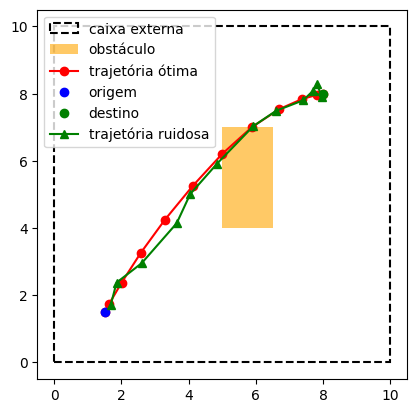

In [2]:
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from numpy import random

# ---------------------------
# Modelo de Otimização
# ---------------------------
mdl = Model("LPCLimitado_NaoConvexo")

# Parâmetros de dinâmica
deltaT = 1.0
m = 2.0

# Instantes (waypoints)
T = 12
times = [str(i) for i in range(T)]
nWP = len(times) - 1
print("Número de waypoints:", nWP)

# ---------------------------
# Variáveis de decisão
# ---------------------------
x  = mdl.addVars(times, name="x")
y  = mdl.addVars(times, name="y")
vx = mdl.addVars(times, lb=-1, ub=1, name="vx")
vy = mdl.addVars(times, lb=-1, ub=1, name="vy")
Fx = mdl.addVars(times, lb=-1, ub=1, name="Fx")
Fy = mdl.addVars(times, lb=-1, ub=1, name="Fy")
obj = mdl.addVar(name="obj")  # (não usado diretamente; mantido por paridade com seu modelo)

# ---------------------------
# Restrições de dinâmica
# ---------------------------
for k in range(nWP):
    t, t1 = times[k], times[k+1]

    # Posição
    mdl.addConstr(
        x[t1] == x[t] + vx[t]*deltaT + 0.5*(deltaT**2)*Fx[t]/m,
        name=f"xpos_{k}"
    )
    mdl.addConstr(
        y[t1] == y[t] + vy[t]*deltaT + 0.5*(deltaT**2)*Fy[t]/m,
        name=f"ypos_{k}"
    )

    # Velocidade
    mdl.addConstr(vx[t1] == vx[t] + deltaT*Fx[t]/m, name=f"vx_{k}")
    mdl.addConstr(vy[t1] == vy[t] + deltaT*Fy[t]/m, name=f"vy_{k}")

# ---------------------------
# Condições inicial e final
# ---------------------------
mdl.addConstr(x[times[0]] == 1.5, name="x0")
mdl.addConstr(y[times[0]] == 1.5, name="y0")
mdl.addConstr(vx[times[0]] == 0.0, name="vx0")
mdl.addConstr(vy[times[0]] == 0.0, name="vy0")

mdl.addConstr(x[times[nWP]] == 8.0, name="x_goal")
mdl.addConstr(y[times[nWP]] == 8.0, name="y_goal")
mdl.addConstr(vx[times[nWP]] == 0.0, name="vx_goal")
mdl.addConstr(vy[times[nWP]] == 0.0, name="vy_goal")

# ---------------------------
# Limites externos (caixa) e região NÃO CONVEXA
# ---------------------------
# Caixa de trabalho (mantém a trajetória num quadrado 0..10)
for t in times:
    mdl.addConstr(x[t] >= 0, name=f"box_xmin_{t}")
    mdl.addConstr(x[t] <= 10, name=f"box_xmax_{t}")
    mdl.addConstr(y[t] >= 0, name=f"box_ymin_{t}")
    mdl.addConstr(y[t] <= 10, name=f"box_ymax_{t}")

# Obstáculo retangular proibido (não pode entrar):
# Defina como quiser; este exemplo cria um retângulo no centro.
x_min_obs, x_max_obs = 5.0, 6.5
y_min_obs, y_max_obs = 4.0, 7.0

# Modelagem disjuntiva: para cada t, (x,y) deve estar FORA do retângulo.
# "Fora" significa satisfazer pelo menos UMA das 4 desigualdades:
#   x <= x_min_obs - eps   OU
#   x >= x_max_obs + eps   OU
#   y <= y_min_obs - eps   OU
#   y >= y_max_obs + eps
# Usamos binárias b1..b4 e Big-M.
M   = 1e3
eps = 1e-3

b1 = mdl.addVars(times, vtype=GRB.BINARY, name="b_left")    # ativa x <= x_min_obs - eps
b2 = mdl.addVars(times, vtype=GRB.BINARY, name="b_right")   # ativa x >= x_max_obs + eps
b3 = mdl.addVars(times, vtype=GRB.BINARY, name="b_down")    # ativa y <= y_min_obs - eps
b4 = mdl.addVars(times, vtype=GRB.BINARY, name="b_up")      # ativa y >= y_max_obs + eps

for t in times:
    # Pelo menos uma borda deve estar "ativa"
    mdl.addConstr(b1[t] + b2[t] + b3[t] + b4[t] >= 1, name=f"outside_or_{t}")

    # Big-M para cada disjuntiva
    mdl.addConstr(x[t] <= (x_min_obs - eps) + M*(1 - b1[t]), name=f"left_{t}")
    mdl.addConstr(x[t] >= (x_max_obs + eps) - M*(1 - b2[t]), name=f"right_{t}")
    mdl.addConstr(y[t] <= (y_min_obs - eps) + M*(1 - b3[t]), name=f"down_{t}")
    mdl.addConstr(y[t] >= (y_max_obs + eps) - M*(1 - b4[t]), name=f"up_{t}")

# Observação:
# O conjunto permitido é (caixa externa) \ (retângulo do obstáculo).
# Isso é NÃO CONVEXO e a modelagem acima garante evitar o retângulo.

# ---------------------------
# Função Objetivo (mesma do modelo original)
# ---------------------------
mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(Fx[t]*Fx[t] + Fy[t]*Fy[t] for t in times))

# ---------------------------
# Resolução
# ---------------------------
mdl.optimize()

# ---------------------------
# Extração de resultados
# ---------------------------
traj_x = [x[t].X for t in times]
traj_y = [y[t].X for t in times]
forces = [(Fx[t].X, Fy[t].X) for t in times]
print("Trajetória X:", traj_x)
print("Trajetória Y:", traj_y)
print("Forças:", forces)

# ---------------------------
# Plot
# ---------------------------
fig, ax = plt.subplots()
ax.set_aspect("equal", adjustable="box")
ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-0.5, 10.5)

# Caixa externa
ax.add_patch(Rectangle((0, 0), 10, 10, fill=False, linestyle="--", linewidth=1.5, label="caixa externa"))

# Obstáculo (preenchido)
obs = Rectangle((x_min_obs, y_min_obs),
                x_max_obs - x_min_obs,
                y_max_obs - y_min_obs,
                facecolor="orange", alpha=0.6, label="obstáculo")
ax.add_patch(obs)

# Trajetória ótima
ax.plot(traj_x, traj_y, "-ro", label="trajetória ótima")
ax.plot(traj_x[0], traj_y[0], "bo", label="origem")
ax.plot(traj_x[-1], traj_y[-1], "go", label="destino")

# (Opcional) Trajetória prevista com pequeno ruído
vel_x = [vx[t].X for t in times]
vel_y = [vy[t].X for t in times]
force_x = [Fx[t].X for t in times]
force_y = [Fy[t].X for t in times]

traj_xr, traj_yr = [], []
for i, t in enumerate(times):
    xr = traj_x[i] + vel_x[i]*deltaT + 0.5*(deltaT**2)*force_x[i]/m + random.normal(0, 0.15)
    yr = traj_y[i] + vel_y[i]*deltaT + 0.5*(deltaT**2)*force_y[i]/m + random.normal(0, 0.15)
    traj_xr.append(xr)
    traj_yr.append(yr)
ax.plot(traj_xr, traj_yr, "-g^", label="trajetória ruidosa")

ax.legend(loc="best")
plt.show()


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 199 rows, 116 columns and 430 nonzeros
Model fingerprint: 0x96219b31
Model has 24 quadratic objective terms
Variable types: 72 continuous, 44 integer (44 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 156 rows and 67 columns
Presolve time: 0.00s
Presolved: 43 rows, 49 columns, 138 nonzeros
Presolved model has 22 quadratic objective terms
Variable types: 44 continuous, 5 integer (5 binary)
Found heuristic solution: objective 4.8312711

Root relaxation: objective 3.072727e+00, 59 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node  

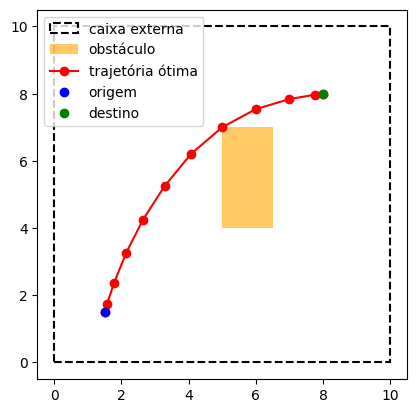

In [11]:
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
import numpy as np

# ==============
# Utilitários
# ==============
def rectangle_outside_halfspaces(xmin, ymin, xmax, ymax):
    """
    Retorna (A, b) para o retângulo proibido tal que
    estar FORA do retângulo é descrito por uma disjunção de meios-espaços:
        a_i^T [x,y] <= b_i  para pelo menos um i.
    Faces (normais apontando para fora):
        x <= xmin        -> a=[1,0],  b=xmin
        x >= xmax (=> -x <= -xmax) -> a=[-1,0], b=-xmax
        y <= ymin        -> a=[0,1],  b=ymin
        y >= ymax (=> -y <= -ymax) -> a=[0,-1], b=-ymax
    """
    A = np.array([
        [ 1.0,  0.0],   # x <= xmin
        [-1.0,  0.0],   # -x <= -xmax
        [ 0.0,  1.0],   # y <= ymin
        [ 0.0, -1.0],   # -y <= -ymax
    ])
    b = np.array([xmin, -xmax, ymin, -ymax], dtype=float)
    return A, b

def add_same_side_encoding(mdl, xvars, yvars, times, obstacles_Ab, bigM=1e3, risk_margin=None):
    """
    Codifica, para cada obstáculo (A,b) e para cada segmento [t,t+1],
    que os pontos (x_t,y_t) e (x_{t+1},y_{t+1}) fiquem no MESMO lado
    de ao menos uma face do polígono (disjunção com binárias).

    risk_margin: None (determinístico) ou array/list com deslocamentos κ_i>=0
                 do mesmo tamanho de cada b (chance-constraint simples).
    """
    nWP = len(times) - 1
    for obs_idx, (A, b) in enumerate(obstacles_Ab):
        m_faces = A.shape[0]
        kappa = np.zeros_like(b) if risk_margin is None else np.asarray(risk_margin, dtype=float)
        assert kappa.shape == b.shape

        # binárias z_{t,i} para "ativar" a face i no segmento t
        z = mdl.addVars(range(nWP), range(m_faces), vtype=GRB.BINARY,
                        name=f"z_obs{obs_idx}")

        for t in range(nWP):
            t0, t1 = times[t], times[t+1]

            # precisa ativar pelo menos uma face por segmento
            mdl.addConstr(quicksum(z[t, i] for i in range(m_faces)) >= 1,
                          name=f"obs{obs_idx}_seg{t}_or")

            # para cada face i: impõe mesmo lado para (t) e (t+1)
            for i in range(m_faces):
                a1, a2 = float(A[i,0]), float(A[i,1])
                bi = float(b[i]) - float(kappa[i])  # margem de risco (se houver)

                # a_i^T x_t <= b_i + M (1 - z)
                mdl.addConstr(a1 * xvars[t0] + a2 * yvars[t0] <= bi + bigM*(1 - z[t, i]),
                              name=f"obs{obs_idx}_seg{t}_i{i}_t0")
                mdl.addConstr(a1 * xvars[t1] + a2 * yvars[t1] <= bi + bigM*(1 - z[t, i]),
                              name=f"obs{obs_idx}_seg{t}_i{i}_t1")


# ===========================
# Modelo principal (dinâmica)
# ===========================
mdl = Model("LPC_NaoConvexo_CFEncoding")

# Dinâmica (mesma do seu modelo)
deltaT = 1.0
m = 2.0
times = [str(i) for i in range(12)]
nWP = len(times) - 1

# Variáveis
x  = mdl.addVars(times, name="x")
y  = mdl.addVars(times, name="y")
vx = mdl.addVars(times, lb=-1, ub=1, name="vx")
vy = mdl.addVars(times, lb=-1, ub=1, name="vy")
Fx = mdl.addVars(times, lb=-1, ub=1, name="Fx")
Fy = mdl.addVars(times, lb=-1, ub=1, name="Fy")

# Dinâmica discreta
for t in range(nWP):
    t0, t1 = times[t], times[t+1]
    mdl.addConstr(x[t1] == x[t0] + vx[t0]*deltaT + 0.5*(deltaT**2)*Fx[t0]/m, name=f"xpos_{t}")
    mdl.addConstr(y[t1] == y[t0] + vy[t0]*deltaT + 0.5*(deltaT**2)*Fy[t0]/m, name=f"ypos_{t}")
    mdl.addConstr(vx[t1] == vx[t0] + deltaT*Fx[t0]/m, name=f"vx_{t}")
    mdl.addConstr(vy[t1] == vy[t0] + deltaT*Fy[t0]/m, name=f"vy_{t}")

# Condições inicial e final
mdl.addConstr(x[times[0]] == 1.5, name="x0")
mdl.addConstr(y[times[0]] == 1.5, name="y0")
mdl.addConstr(vx[times[0]] == 0.0, name="vx0")
mdl.addConstr(vy[times[0]] == 0.0, name="vy0")

mdl.addConstr(x[times[nWP]] == 8.0, name="x_goal")
mdl.addConstr(y[times[nWP]] == 8.0, name="y_goal")
mdl.addConstr(vx[times[nWP]] == 0.0, name="vx_goal")
mdl.addConstr(vy[times[nWP]] == 0.0, name="vy_goal")

# Caixa externa de operação
for t in times:
    mdl.addConstr(x[t] >= 0, name=f"box_xmin_{t}")
    mdl.addConstr(x[t] <= 10, name=f"box_xmax_{t}")
    mdl.addConstr(y[t] >= 0, name=f"box_ymin_{t}")
    mdl.addConstr(y[t] <= 10, name=f"box_ymax_{t}")

# ===========================
# Obstáculos e codificação CF
# ===========================
# Exemplo: um retângulo proibido central (não convexo = caixa externa \ obstáculo)
xmin_obs, ymin_obs = 5.0, 4.0
xmax_obs, ymax_obs = 6.5, 7.0
A_rect, b_rect = rectangle_outside_halfspaces(xmin_obs, ymin_obs, xmax_obs, ymax_obs)

# (Opcional) margem simples de risco para cada face (chance-constraint):
use_chance_margin = False
if use_chance_margin:
    # Exemplo com Sigma = sigma^2 I e alocação uniforme epsilon
    sigma = 0.15
    eps   = 0.01  # prob. de violação por face/segmento (exemplo)
    from math import sqrt
    from math import erf
    # Φ^{-1}(1-ε) via relação com erf^{-1} (ou use scipy se disponível)
    # aproximação rápida:
    from math import log
    # Winitzki approximation for erfinv (para manter self-contained)
    def erfinv(y):
        a = 0.147  # const
        sgn = 1 if y > 0 else -1
        ln = np.log(1 - y*y)
        first = 2/(np.pi*a) + ln/2
        return sgn * np.sqrt( np.sqrt(first*first - ln/a) - first )
    PhiInv = sqrt(2) * erfinv(1 - 2*eps)
    kappa = PhiInv * sigma * np.linalg.norm(A_rect, axis=1)  # sqrt(a^T Σ a) com Σ = σ^2 I
else:
    kappa = None

# Adiciona a codificação "mesmo lado" (Arantes et al., 2019)
add_same_side_encoding(mdl, x, y, times, obstacles_Ab=[(A_rect, b_rect)],
                       bigM=1e3, risk_margin=kappa)

# ===========================
# Objetivo (mesmo do original)
# ===========================
mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(Fx[t]*Fx[t] + Fy[t]*Fy[t] for t in times))

# ===========================
# Otimização
# ===========================
mdl.optimize()

# ===========================
# Pós-processamento c/ checagem
# ===========================
if mdl.status == GRB.OPTIMAL:
    traj_x = [x[t].X for t in times]
    traj_y = [y[t].X for t in times]

    # Plot
    fig, ax = plt.subplots()
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-0.5, 10.5)
    ax.set_ylim(-0.5, 10.5)

    # Caixa externa
    ax.add_patch(Rectangle((0,0), 10, 10, fill=False, linestyle="--", linewidth=1.5, label="caixa externa"))

    # Obstáculo (retângulo proibido)
    ax.add_patch(Rectangle((xmin_obs, ymin_obs),
                           xmax_obs - xmin_obs,
                           ymax_obs - ymin_obs,
                           facecolor="orange", alpha=0.6, label="obstáculo"))

    # Trajetória
    ax.plot(traj_x, traj_y, "-ro", label="trajetória ótima")
    ax.plot(traj_x[0], traj_y[0], "bo", label="origem")
    ax.plot(traj_x[-1], traj_y[-1], "go", label="destino")

    ax.legend(loc="best")
    plt.show()
else:
    print("Modelo não retornou solução ótima. Status:", mdl.status)
    # Dica: mdl.write("modelo.lp")


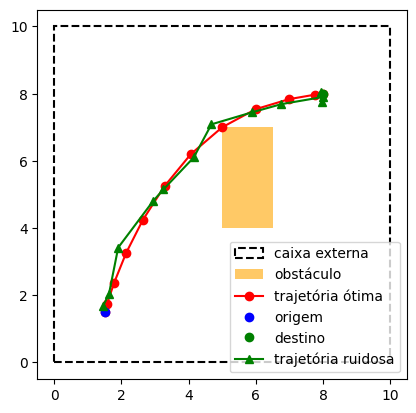

In [12]:
if mdl.status == GRB.OPTIMAL:
    traj_x = [x[t].X for t in times]
    traj_y = [y[t].X for t in times]

    # Plot
    fig, ax = plt.subplots()
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-0.5, 10.5)
    ax.set_ylim(-0.5, 10.5)

    # Caixa externa
    ax.add_patch(Rectangle((0,0), 10, 10, fill=False,
                           linestyle="--", linewidth=1.5,
                           label="caixa externa"))

    # Obstáculo (retângulo proibido)
    ax.add_patch(Rectangle((xmin_obs, ymin_obs),
                           xmax_obs - xmin_obs,
                           ymax_obs - ymin_obs,
                           facecolor="orange", alpha=0.6, label="obstáculo"))

    # Trajetória ótima
    ax.plot(traj_x, traj_y, "-ro", label="trajetória ótima")
    ax.plot(traj_x[0], traj_y[0], "bo", label="origem")
    ax.plot(traj_x[-1], traj_y[-1], "go", label="destino")

    # ------------------------
    # Trajetória ruidosa
    # ------------------------
    vel_x = [vx[t].X for t in times]
    vel_y = [vy[t].X for t in times]
    force_x = [Fx[t].X for t in times]
    force_y = [Fy[t].X for t in times]

    traj_xr, traj_yr = [], []
    for i, t in enumerate(times):
        xr = traj_x[i] + vel_x[i]*deltaT + 0.5*(deltaT**2)*force_x[i]/m + np.random.normal(0, 0.2)
        yr = traj_y[i] + vel_y[i]*deltaT + 0.5*(deltaT**2)*force_y[i]/m + np.random.normal(0, 0.2)
        traj_xr.append(xr)
        traj_yr.append(yr)

    ax.plot(traj_xr, traj_yr, "-g^", label="trajetória ruidosa")

    ax.legend(loc="best")
    plt.show()
else:
    print("Modelo não retornou solução ótima. Status:", mdl.status)
